# Set up

In [1]:
from footbot.data import utils
import pandas as pd
import patsy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)

# Getting data

In [4]:
client = utils.set_up_bigquery(secrets_path='../secrets/service_account.json')

In [113]:
sql = \
'''
SELECT
  event,
  element,
  total_points,
  safe_web_name,
  element_type,
  cluster,
  team,
  value,
  total_points_per_minute_previous_season,
  goals_scored_per_minute_previous_season,
  assists_per_minute_previous_season,
  clean_sheets_per_minute_previous_season,
  goals_conceded_per_minute_previous_season,
  own_goals_per_minute_previous_season,
  penalties_saved_per_minute_previous_season,
  penalties_missed_per_minute_previous_season,
  yellow_cards_per_minute_previous_season,
  red_cards_per_minute_previous_season,
  saves_per_minute_previous_season,
  bonus_per_minute_previous_season,
  bps_per_minute_previous_season,
  opponent_team,
  was_home,
  was_sunday,
  was_weekday,
  was_late,
  was_early,
  rolling_avg_total_points_element,
  rolling_avg_minutes_element,
  rolling_avg_goals_scored_element,
  rolling_avg_assists_element,
  rolling_avg_clean_sheets_element,
  rolling_avg_goals_conceded_element,
  rolling_avg_own_goals_element,
  rolling_avg_penalties_saved_element,
  rolling_avg_penalties_missed_element,
  rolling_avg_yellow_cards_element,
  rolling_avg_red_cards_element,
  rolling_avg_saves_element,
  rolling_avg_bonus_element,
  rolling_avg_bps_element,
  rolling_avg_total_points_element_p1,
  rolling_avg_total_points_element_p2,
  rolling_avg_total_points_element_p3,
  rolling_avg_total_points_element_p4,
  rolling_avg_total_points_element_p5,
  rolling_avg_total_points_element_p10,
  rolling_avg_goals_scored_element_p1,
  rolling_avg_goals_scored_element_p2,
  rolling_avg_goals_scored_element_p3,
  rolling_avg_goals_scored_element_p4,
  rolling_avg_goals_scored_element_p5,
  rolling_avg_goals_scored_element_p10,
  rolling_avg_assists_element_p1,
  rolling_avg_assists_element_p2,
  rolling_avg_assists_element_p3,
  rolling_avg_assists_element_p4,
  rolling_avg_assists_element_p5,
  rolling_avg_assists_element_p10,
  rolling_avg_clean_sheets_element_p1,
  rolling_avg_clean_sheets_element_p2,
  rolling_avg_clean_sheets_element_p3,
  rolling_avg_clean_sheets_element_p4,
  rolling_avg_clean_sheets_element_p5,
  rolling_avg_clean_sheets_element_p10,
  rolling_avg_goals_conceded_element_p1,
  rolling_avg_goals_conceded_element_p2,
  rolling_avg_goals_conceded_element_p3,
  rolling_avg_goals_conceded_element_p4,
  rolling_avg_goals_conceded_element_p5,
  rolling_avg_goals_conceded_element_p10,
  rolling_avg_saves_element_p1,
  rolling_avg_saves_element_p2,
  rolling_avg_saves_element_p3,
  rolling_avg_saves_element_p4,
  rolling_avg_saves_element_p5,
  rolling_avg_saves_element_p10,
  rolling_avg_minutes_element_p1,
  rolling_avg_minutes_element_p2,
  rolling_avg_minutes_element_p3,
  rolling_avg_minutes_element_p4,
  rolling_avg_minutes_element_p5,
  rolling_avg_minutes_element_p10,
  expected_total_points_against_opponent_team_element_type,
  expected_minutes_against_opponent_team_element_type,
  expected_goals_scored_against_opponent_team_element_type,
  expected_assists_against_opponent_team_element_type,
  expected_clean_sheets_against_opponent_team_element_type,
  expected_goals_conceded_against_opponent_team_element_type,
  expected_own_goals_against_opponent_team_element_type,
  expected_penalties_saved_against_opponent_team_element_type,
  expected_penalties_missed_against_opponent_team_element_type,
  expected_yellow_cards_against_opponent_team_element_type,
  expected_red_cards_against_opponent_team_element_type,
  expected_saves_against_opponent_team_element_type,
  expected_bonus_against_opponent_team_element_type,
  expected_bps_against_opponent_team_element_type,
  rolling_avg_squad,
  rolling_avg_first_team,
  rolling_avg_vice_or_captain,
  rolling_avg_squad_p1,
  rolling_avg_first_team_p1,
  rolling_avg_vice_or_captain_p1
FROM
  `footbot-001.fpl.element_gameweeks_features_1819_v01`
'''

In [ ]:
# get dataframe
df_all = client.query(sql).to_dataframe()

In [200]:
last_train_event = 25
last_test_event = 38
element_filter_field = 'rolling_avg_total_points_element'
element_filter_value = 2

In [201]:
# filter out elements
element_filter_df = df_all[df_all['event'] == last_train_event + 1]

element_filter = element_filter_df[
    element_filter_df[element_filter_field] > element_filter_value
]['element'].values

df = df_all[
    (df_all['event'] <= last_test_event)
    & (df_all['element'].isin(element_filter))
]

# impute missing values by element type
df = pd.concat([
    df[df['element_type'] == i].fillna(
        df[
            (df['event'] <= last_train_event)
            & (df['element_type'] == i)
        ].mean()).fillna(0)
    for i in range(1, 5)
])

In [202]:
df = df[df['element_type'] != 1]

# Modelling data

## Splitting data

In [203]:
test_fold = [-1 if i <= last_train_event else 0 for i in df['event']]
ps = PredefinedSplit(test_fold)

In [204]:
for train_index, test_index in ps.split():
    df_train, df_test = \
    df.copy().iloc[train_index], df.copy().iloc[test_index]

## Scaling data

In [205]:
list(df.columns)

['event',
 'element',
 'total_points',
 'safe_web_name',
 'element_type',
 'cluster',
 'team',
 'value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'opponent_team',
 'was_home',
 'was_sunday',
 'was_weekday',
 'was_late',
 'was_early',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_a

In [206]:
scaled_feature_cols = [
    i for i in df.columns if i not in [
        'total_points',
        'goals_scored',
        'assists',
        'clean_sheets',
        'goals_conceded',
        'saves',
        'minutes',
        'element',
        'safe_web_name',
        'element_type',
        'cluster',
        'team',
        'event',
        'fixture',
        'opponent_team',
        'was_home',
        'was_sunday',
        'was_weekday',
        'was_late',
        'was_early',
    ]
]

scaled_feature_cols

['value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_avg_penalties_saved_element',
 'rolling_avg_penalties_missed_element',
 'rolling_avg_yellow_cards_element',
 'rolling_avg_red_cards_element',
 'rolling_avg_saves_element',
 'rolling_avg

In [207]:
scaled_df_train = df_train.copy()
scaled_df_test = df_test.copy()
scaled_df = df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

df_train[scaled_feature_cols] = scaled_df_train
df_test[scaled_feature_cols] = scaled_df_test
df[scaled_feature_cols] = scaled_df

## Building model

In [208]:
formula = \
'''
total_points
~ C(element_type)
+ C(opponent_team)
+ C(team)
+ C(was_home)
+ C(was_sunday)
+ C(was_weekday)
+ C(was_late)
+ C(was_early)
+
'''  + ' + '.join(scaled_feature_cols)

In [209]:
print(formula)


total_points
~ C(element_type)
+ C(opponent_team)
+ C(team)
+ was_home
+ was_sunday
+ was_weekday
+ was_late
+ was_early
+
value + total_points_per_minute_previous_season + goals_scored_per_minute_previous_season + assists_per_minute_previous_season + clean_sheets_per_minute_previous_season + goals_conceded_per_minute_previous_season + own_goals_per_minute_previous_season + penalties_saved_per_minute_previous_season + penalties_missed_per_minute_previous_season + yellow_cards_per_minute_previous_season + red_cards_per_minute_previous_season + saves_per_minute_previous_season + bonus_per_minute_previous_season + bps_per_minute_previous_season + rolling_avg_total_points_element + rolling_avg_minutes_element + rolling_avg_goals_scored_element + rolling_avg_assists_element + rolling_avg_clean_sheets_element + rolling_avg_goals_conceded_element + rolling_avg_own_goals_element + rolling_avg_penalties_saved_element + rolling_avg_penalties_missed_element + rolling_avg_yellow_cards_element + r

In [210]:
y, X = patsy.dmatrices(formula, df, return_type='matrix')

In [211]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

### Least squares

In [212]:
ls_estimator = LinearRegression()

ls_selector = RFECV(
    ls_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

ls_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [213]:
sum(ls_selector.support_)

84

In [214]:
-ls_selector.grid_scores_[-1]

10.594816390126127

In [215]:
ls_sel_cols = list(pd.Series(X.design_info.column_names)[ls_selector.support_])
ls_sel_cols

['C(element_type)[T.4]',
 'C(opponent_team)[T.bournemouth]',
 'C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.burnley]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.chelsea]',
 'C(opponent_team)[T.crystal palace]',
 'C(opponent_team)[T.everton]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.newcastle]',
 'C(opponent_team)[T.southampton]',
 'C(opponent_team)[T.watford]',
 'C(opponent_team)[T.west ham]',
 'C(opponent_team)[T.wolves]',
 'C(team)[T.bournemouth]',
 'C(team)[T.brighton]',
 'C(team)[T.chelsea]',
 'C(team)[T.crystal palace]',
 'C(team)[T.everton]',
 'C(team)[T.fulham]',
 'C(team)[T.huddersfield]',
 'C(team)[T.liverpool]',
 'C(team)[T.man city]',
 'C(team)[T.man utd]',
 'C(team)[T.newcastle]',
 'C(team)[T.southampton]',
 'C(team)[T.spurs]',
 'C(team)[T.watford]',
 'C(team)[T.west ham]',
 'C

In [216]:
ls_X_sel = X[:,ls_selector.support_]
ls_X_train_sel = X_train[:,ls_selector.support_]
ls_X_test_sel = X_test[:,ls_selector.support_]

In [219]:
ls_estimator.fit(ls_X_train_sel, y_train)
pd.DataFrame(
    list(zip(ls_sel_cols, list(ls_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False).round()

,feature,weight
53,rolling_avg_penalties_saved_element,3.201800e+11
8,C(opponent_team)[T.fulham],1.464609e+00
4,C(opponent_team)[T.cardiff],1.427400e+00
9,C(opponent_team)[T.huddersfield],1.415886e+00
3,C(opponent_team)[T.burnley],1.299623e+00
15,C(opponent_team)[T.southampton],1.001429e+00
17,C(opponent_team)[T.west ham],9.778396e-01
19,C(team)[T.bournemouth],8.965709e-01
1,C(opponent_team)[T.bournemouth],8.673833e-01
26,C(team)[T.liverpool],8.654340e-01


### Ridge

In [242]:
ridge_estimator = Ridge(alpha=170)

ridge_selector = RFECV(
    ridge_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

ridge_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=170, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [243]:
sum(ridge_selector.support_)

80

In [244]:
-ridge_selector.grid_scores_[-1]

10.517932504613311

In [245]:
ridge_sel_cols = list(pd.Series(X.design_info.column_names)[ridge_selector.support_])
ridge_sel_cols

['C(element_type)[T.3]',
 'C(opponent_team)[T.bournemouth]',
 'C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.burnley]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.crystal palace]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.southampton]',
 'C(opponent_team)[T.spurs]',
 'C(opponent_team)[T.watford]',
 'C(opponent_team)[T.west ham]',
 'C(opponent_team)[T.wolves]',
 'C(team)[T.bournemouth]',
 'C(team)[T.cardiff]',
 'C(team)[T.chelsea]',
 'C(team)[T.crystal palace]',
 'C(team)[T.everton]',
 'C(team)[T.fulham]',
 'C(team)[T.huddersfield]',
 'C(team)[T.leicester]',
 'C(team)[T.liverpool]',
 'C(team)[T.man city]',
 'C(team)[T.man utd]',
 'C(team)[T.newcastle]',
 'C(team)[T.spurs]',
 'C(team)[T.west ham]',
 'was_home',
 'was_weekday',
 'was_late',
 'was_early',
 'value',
 'total_points_per_minute_previ

In [246]:
ridge_X_sel = X[:,ridge_selector.support_]
ridge_X_train_sel = X_train[:,ridge_selector.support_]
ridge_X_test_sel = X_test[:,ridge_selector.support_]

In [247]:
ridge_estimator.fit(ridge_X_train_sel, y_train)
pd.DataFrame(
    list(zip(ridge_sel_cols, list(ridge_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
35,value,0.538743
6,C(opponent_team)[T.fulham],0.393621
4,C(opponent_team)[T.cardiff],0.309735
25,C(team)[T.liverpool],0.300909
36,total_points_per_minute_previous_season,0.297669
7,C(opponent_team)[T.huddersfield],0.295234
3,C(opponent_team)[T.burnley],0.284383
19,C(team)[T.chelsea],0.279335
74,expected_minutes_against_opposition_team_element_type,0.265820
31,was_home,0.265294


### Lasso

In [248]:
lasso_estimator = Lasso(alpha=0.0078)

lasso_selector = RFECV(
    lasso_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

lasso_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=0.0078, copy_X=True, fit_intercept=True,
                      max_iter=1000, normalize=False, positive=False,
                      precompute=False, random_state=None, selection='cyclic',
                      tol=0.0001, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [249]:
sum(lasso_selector.support_)

61

In [250]:
-lasso_selector.grid_scores_[-1]

10.535410045696853

In [251]:
lasso_sel_cols = list(pd.Series(X.design_info.column_names)[lasso_selector.support_])
lasso_sel_cols

['C(element_type)[T.3]',
 'C(opponent_team)[T.bournemouth]',
 'C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.spurs]',
 'C(opponent_team)[T.wolves]',
 'C(team)[T.bournemouth]',
 'C(team)[T.chelsea]',
 'C(team)[T.crystal palace]',
 'C(team)[T.everton]',
 'C(team)[T.liverpool]',
 'C(team)[T.man utd]',
 'C(team)[T.spurs]',
 'was_home',
 'was_late',
 'was_early',
 'value',
 'total_points_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_penalties_missed_element',
 'rolling_avg_bonus_

In [252]:
lasso_X_sel = X[:,lasso_selector.support_]
lasso_X_train_sel = X_train[:,lasso_selector.support_]
lasso_X_test_sel = X_test[:,lasso_selector.support_]

In [253]:
lasso_estimator.fit(lasso_X_train_sel, y_train)
pd.DataFrame(
    list(zip(lasso_sel_cols, list(lasso_estimator.coef_))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
21,value,0.586473
4,C(opponent_team)[T.fulham],0.578294
3,C(opponent_team)[T.cardiff],0.458026
12,C(team)[T.chelsea],0.453238
15,C(team)[T.liverpool],0.450702
11,C(team)[T.bournemouth],0.441083
5,C(opponent_team)[T.huddersfield],0.372120
51,rolling_avg_minutes_element_p1,0.308469
18,was_home,0.291023
54,expected_minutes_against_opposition_team_element_type,0.262080


## Tuning model

### GP tuner

#### Ridge

In [232]:
ridge_space  = [
    Real(10**-8, 10**5, 'log-uniform', name='alpha')
]

In [258]:
ridge_gp_model = Ridge()

@use_named_args(ridge_space)
def ridge_objective(**params):
    ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            ridge_gp_model,
#             np.asarray(X),
            np.asarray(ridge_X_sel),
            np.asarray(y).ravel(),
            cv=ps,
            scoring="neg_mean_squared_error"))

In [259]:
ridge_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    ridge_res_gp = gp_minimize(
        ridge_objective,
        ridge_space,
        n_calls=50,
        n_jobs=-1,
        verbose=2
    )
    ridge_res_gp_arr.append(ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0403
Function value obtained: 10.4759
Current minimum: 10.4759
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0259
Function value obtained: 10.4306
Current minimum: 10.4306
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0277
Function value obtained: 11.0884
Current minimum: 10.4306
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0182
Function value obtained: 10.4759
Current minimum: 10.4306
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0278
Function value obtained: 10.4759
Current minimum: 10.4306


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.7381
Function value obtained: 10.4305
Current minimum: 10.4298
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.0937
Function value obtained: 10.4298
Current minimum: 10.4298
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.2187
Function value obtained: 10.4298
Current minimum: 10.4298
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.1840
Function value obtained: 10.4298
Current minimum: 10.4298
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.1382
Function value obtained: 10.4306
Current minimum: 10.4298
Iteration No: 46 st

In [260]:
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

10.429775866574559


[87.39782873212226]


In [261]:
ridge_estimator = Ridge(alpha=ridge_res_gp_arr[0].x[0])
ridge_estimator.fit(X_train, y_train)
pd.DataFrame(
    list(zip(X.design_info.column_names, list(ridge_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
46,value,0.549446
10,C(opponent_team)[T.fulham],0.542400
6,C(opponent_team)[T.cardiff],0.442802
32,C(team)[T.liverpool],0.424040
11,C(opponent_team)[T.huddersfield],0.418497
5,C(opponent_team)[T.burnley],0.411343
26,C(team)[T.chelsea],0.398222
117,expected_minutes_against_opposition_team_element_type,0.364913
22,C(team)[T.bournemouth],0.335657
95,rolling_avg_clean_sheets_element_p4,0.312890


#### Lasso

In [237]:
lasso_space  = [
    Real(10**-8, 10**3, 'log-uniform', name='alpha')
]

In [262]:
lasso_gp_model = Lasso()

@use_named_args(lasso_space)
def lasso_objective(**params):
    lasso_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lasso_gp_model,
#             np.asarray(X),
            np.asarray(lasso_X_sel),
            np.asarray(y).ravel(),
            cv=ps,
            scoring="neg_mean_squared_error"))

In [263]:
lasso_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    lasso_res_gp = gp_minimize(
        lasso_objective,
        lasso_space,
        n_calls=50,
        n_jobs=-1,
        verbose=2
    )
    lasso_res_gp_arr.append(lasso_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0984
Function value obtained: 10.4974
Current minimum: 10.4974
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1968
Function value obtained: 10.3525
Current minimum: 10.3525
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0293
Function value obtained: 12.1986
Current minimum: 10.3525
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0133
Function value obtained: 12.1986
Current minimum: 10.3525
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0514
Function value obtained: 10.3767
Current minimum: 10.3525


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.3285
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.2846
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.1285
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.3296
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.9845
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.0861
Function value obtained: 10.3526
Current minimum: 10.3523
Iteration No: 30 st

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.6746
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.8533
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.3940
Function value obtained: 10.3532
Current minimum: 10.3523
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.6149
Function value obtained: 10.3524
Current minimum: 10.3523
Iteration No: 36 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.8148
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.4941
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.6445
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.6731
Function value obtained: 10.3551
Current minimum: 10.3523
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.6583
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 41 st

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.0997
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.7245
Function value obtained: 10.3525
Current minimum: 10.3523
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.0745
Function value obtained: 10.3524
Current minimum: 10.3523
Iteration No: 46 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.8740
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.4581
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.7457
Function value obtained: 10.3523
Current minimum: 10.3523
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.6529
Function value obtained: 10.3528
Current minimum: 10.3523
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.6226
Function value obtained: 10.3523
Current minimum: 10.3523


In [264]:
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

10.35228691772087


[1e-08]


In [265]:
lasso_estimator = Lasso(alpha=lasso_res_gp_arr[0].x[0])
lasso_estimator.fit(X_train, y_train)
lasso_gp_df = pd.DataFrame(
    list(zip(X.design_info.column_names, list(lasso_estimator.coef_))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

lasso_gp_df[abs(lasso_gp_df['weight']) > 0.001]

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19636.220105797303, tolerance: 4.555916822429912
  positive)


,feature,weight
10,C(opponent_team)[T.fulham],1.419528
11,C(opponent_team)[T.huddersfield],1.348850
6,C(opponent_team)[T.cardiff],1.333420
5,C(opponent_team)[T.burnley],1.309563
22,C(team)[T.bournemouth],1.060166
32,C(team)[T.liverpool],1.008895
26,C(team)[T.chelsea],0.976309
20,C(opponent_team)[T.west ham],0.954135
17,C(opponent_team)[T.southampton],0.924848
3,C(opponent_team)[T.bournemouth],0.822950


# Evaluating model

## Least sqaures

In [266]:
ls_model = LinearRegression()

ls_model.fit(ls_X_train_sel, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [283]:
# get predictions for train set
ls_y_pred_train = ls_model.predict(ls_X_train_sel).flatten()

# calculate cross entropy loss for train set
ls_train_loss = (
    mean_absolute_error(y_train, ls_y_pred_train),
    mean_squared_error(y_train, ls_y_pred_train),
    r2_score(y_train, ls_y_pred_train)
)
ls_train_loss

(2.431351964753086, 10.353052154836792, 0.12465572891734056)

In [267]:
# get predictions for test set
ls_y_pred = ls_model.predict(ls_X_test_sel).flatten()

# calculate cross entropy loss for test set
ls_test_loss = (
    mean_absolute_error(y_test, ls_y_pred),
    mean_squared_error(y_test, ls_y_pred),
    r2_score(y_test, ls_y_pred)
)
ls_test_loss

(2.4039382092259904, 10.444409030672789, 0.1343409198642107)

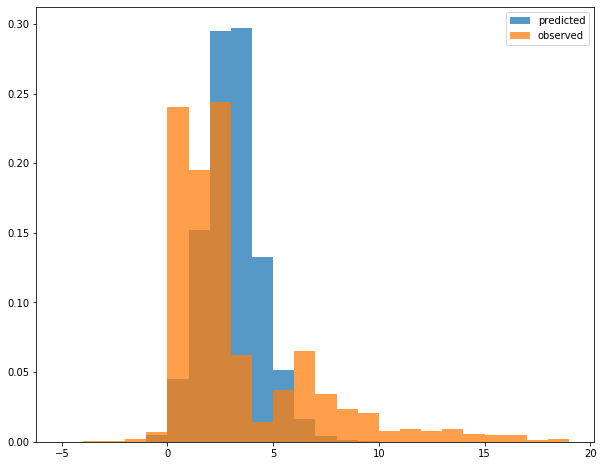

In [268]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ls_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

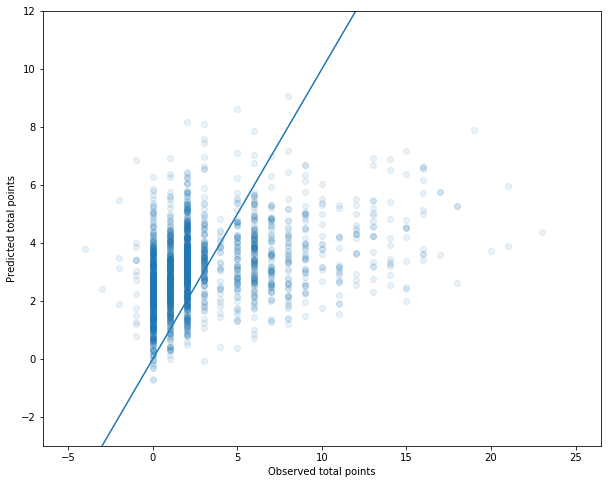

In [269]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(ls_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Ridge

In [270]:
ridge_model = Ridge(alpha=90)

ridge_model.fit(ridge_X_train_sel, y_train.ravel())

Ridge(alpha=90, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [282]:
# get predictions for train set
ridge_y_pred_train = ridge_model.predict(ridge_X_train_sel).flatten()

# calculate cross entropy loss for train set
ridge_train_loss = (
    mean_absolute_error(y_train, ridge_y_pred_train),
    mean_squared_error(y_train, ridge_y_pred_train),
    r2_score(y_train, ridge_y_pred_train)
)
ridge_train_loss

(2.4444781037689802, 10.411967675259772, 0.11967445745180316)

In [271]:
# get predictions for test set
ridge_y_pred = ridge_model.predict(ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
ridge_test_loss = (
    mean_absolute_error(y_test, ridge_y_pred),
    mean_squared_error(y_test, ridge_y_pred),
    r2_score(y_test, ridge_y_pred)
)
ridge_test_loss

(2.396112903896876, 10.42978818397319, 0.13555273267885726)

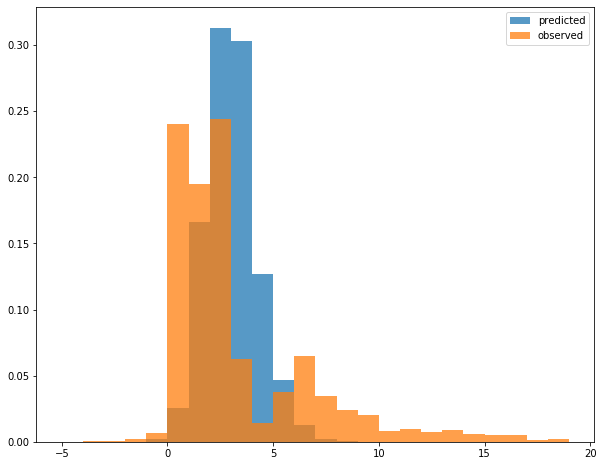

In [272]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

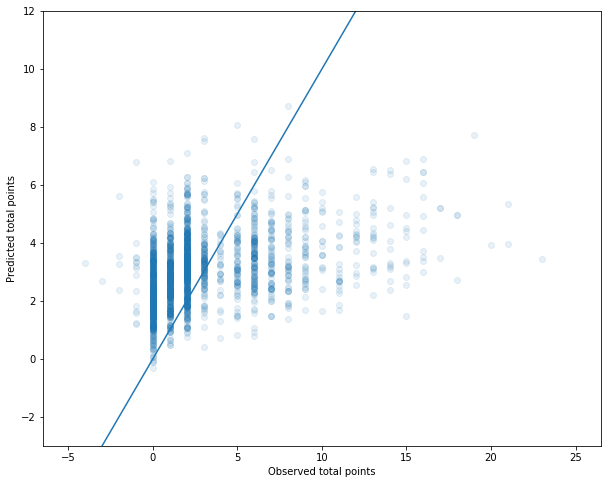

In [273]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Lasso

In [274]:
lasso_model = Ridge(alpha=1e-8)

lasso_model.fit(lasso_X_train_sel, y_train.ravel())

Ridge(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [280]:
# get predictions for train set
lasso_y_pred_train = lasso_model.predict(lasso_X_train_sel).flatten()

# calculate cross entropy loss for train set
lasso_train_loss = (
    mean_absolute_error(y_train, lasso_y_pred_train),
    mean_squared_error(y_train, lasso_y_pred_train),
    r2_score(y_train, lasso_y_pred_train)
)
lasso_train_loss

(2.441192499172779, 10.429374645435487, 0.11820270869671745)

In [281]:
# get predictions for test set
lasso_y_pred_test = lasso_model.predict(lasso_X_test_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss = (
    mean_absolute_error(y_test, lasso_y_pred_test),
    mean_squared_error(y_test, lasso_y_pred_test),
    r2_score(y_test, lasso_y_pred_test)
)
lasso_test_loss

(2.3809302610567817, 10.352286883936484, 0.1419762367662668)

In [284]:
len(y_test)

2146

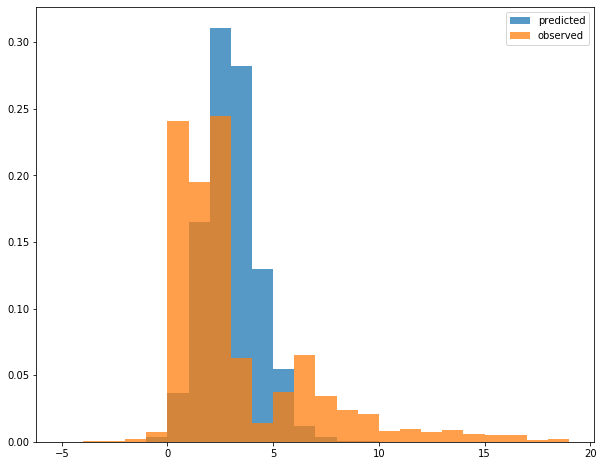

In [276]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

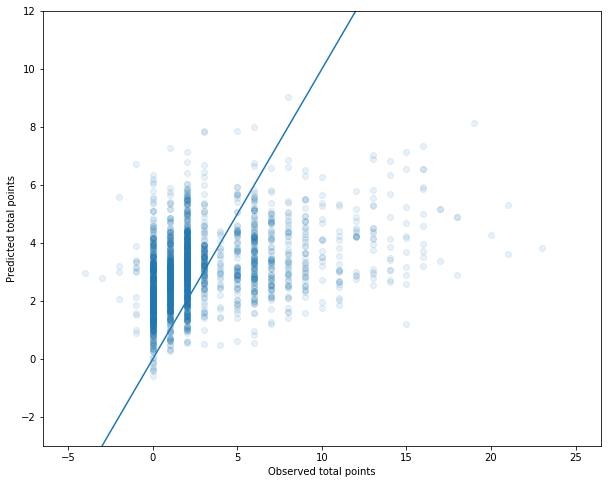

In [277]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(lasso_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [287]:
print('test loss')
print('test observations', len(y_test))
pd.DataFrame([
    ('Least squares', ls_test_loss[0], ls_test_loss[1], ls_test_loss[2]),
    ('Ridge', ridge_test_loss[0], ridge_test_loss[1], ridge_test_loss[2]),
    ('Lasso', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

test loss
test observations 2146


,model,MAE,MSE,r2
0,Least squares,2.403938,10.444409,0.134341
1,Ridge,2.396113,10.429788,0.135553
2,Lasso,2.380930,10.352287,0.141976


In [288]:
print('train loss')
print('train observations', len(y_train))
pd.DataFrame([
    ('Least squares', ls_train_loss[0], ls_train_loss[1], ls_train_loss[2]),
    ('Ridge', ridge_train_loss[0], ridge_train_loss[1], ridge_train_loss[2]),
    ('Lasso', lasso_train_loss[0], lasso_train_loss[1], lasso_train_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

train loss
train observations 3852


,model,MAE,MSE,r2
0,Least squares,2.431352,10.353052,0.124656
1,Ridge,2.444478,10.411968,0.119674
2,Lasso,2.441192,10.429375,0.118203


In [ ]:
print('test loss')
print('test observations', len(y_test))
pd.DataFrame([
    ('Least squares', ls_test_loss[0], ls_test_loss[1], ls_test_loss[2]),
    ('Ridge', ridge_test_loss[0], ridge_test_loss[1], ridge_test_loss[2]),
    ('Lasso', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

print('train loss')
print('train observations', len(y_train))
pd.DataFrame([
    ('Least squares', ls_train_loss[0], ls_train_loss[1], ls_train_loss[2]),
    ('Ridge', ridge_train_loss[0], ridge_train_loss[1], ridge_train_loss[2]),
    ('Lasso', lasso_train_loss[0], lasso_train_loss[1], lasso_train_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])